# DBTL 5 data analysis

This notebook analyzes OD340 and OD600 data from DBTL cycle 1 of a flaviolin producing P. putida.

## Inputs and outputs

#### Required file to run this notebook:
   - edd slug


#### File generated by running this notebook:
   
 
    
The files are stored in the user defined directory.

## Setup

Importing needed libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

import edd_utils as eddu

### User parameters

In [2]:
CYCLE = 5

user_params = {
    'output_file_path': f'../data/flaviolin/DBTL{CYCLE}', # Folder for output files,
    'study_slug': 'combinatorial-media-for-flaviolin-dbtl-5',
    'edd_server': 'edd.jbei.org',
    'username': 'tradivojevic',
    } 

In [3]:
study_slug = user_params['study_slug']
edd_server = user_params['edd_server']
username = user_params['username']

## Load the study

In [4]:
try:
  session = eddu.login(edd_server=edd_server, user=username)
except:
  print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
  print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for tradivojevic:  ··············


OK! Connection to EDD successful. We will try to load data from EDD...


In [5]:
df: pd.DataFrame
    
try:
    df = eddu.export_study(session, study_slug, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    try:
        df = pd.read_csv(user_params['study_file'])
    except:
        print(f'ERROR! Alternative loading of data from disk failed!')
    else:
        print(f'OK! Alternative loading of data from disk was successful.')


  0%|          | 0/96 [00:00<?, ?it/s]

In [6]:
df.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,150417,Combinatorial media for flaviolin DBTL 5,150418,C5_WA1_C1-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,150466,C5_WA1_C1-R1,NaN,Optical Density,0,NaN,0.4472,48.0
1,150417,Combinatorial media for flaviolin DBTL 5,150419,C5_WA1_C1-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,150467,C5_WA1_C1-R2,NaN,Optical Density,0,NaN,0.4533,48.0
2,150417,Combinatorial media for flaviolin DBTL 5,150420,C5_WA1_C1-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,150468,C5_WA1_C1-R3,NaN,Optical Density,0,NaN,0.4918,48.0
3,150417,Combinatorial media for flaviolin DBTL 5,150421,C5_WD1_F1-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,150469,C5_WD1_F1-R1,NaN,Optical Density,0,NaN,0.5900,48.0
4,150417,Combinatorial media for flaviolin DBTL 5,150422,C5_WD1_F1-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,150470,C5_WD1_F1-R2,NaN,Optical Density,0,NaN,0.5333,48.0


Drop unnecessary columns:

In [7]:
df = df.loc[:,['Line Name','Line Description','Protocol','Value']]
df.head()

,Line Name,Line Description,Protocol,Value
0,C5_WA1_C1-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4472
1,C5_WA1_C1-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4533
2,C5_WA1_C1-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4918
3,C5_WD1_F1-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.5900
4,C5_WD1_F1-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.5333


In [8]:
find_col = lambda x: x['Line Name'][5]

def find_row(row):
    line_name = row['Line Name']
    if line_name[4] == 'A':
        if int(line_name[-1]) == 1:
            return "A"
        elif int(line_name[-1]) == 2:
            return "B"
        else:
            return "C"
    else:
        if int(line_name[-1]) == 1:
            return "D"
        elif int(line_name[-1]) == 2:
            return "E"
        else:
            return "F"


In [9]:
df['Row'] =  df.apply(find_row, axis=1)
df['Column'] =  df.apply(find_col, axis=1)


In [10]:
df.head(2)

,Line Name,Line Description,Protocol,Value,Row,Column
0,C5_WA1_C1-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4472,A,1
1,C5_WA1_C1-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4533,B,1


## Coefficient of variation

In [11]:
df_red = df.drop(columns=['Column'])
stats = df_red.groupby(['Protocol', 'Line Description']).mean()
stats.rename(columns={'Value': 'mean'}, inplace=True)
stats['std'] = df_red.groupby(['Protocol', 'Line Description']).std()
stats['CV[%]'] = 100* stats['std'] / stats['mean']
stats

mean  \
Protocol Line Description                                               
OD340    MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.243000   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.612400   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.613033   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.631900   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.564700   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.563233   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.540467   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.621533   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.569900   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.566800   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.604733   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.464100   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.605867   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.498400   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.622900   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.444300   
OD600    MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  1.205000   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.864333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.974000   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.844667   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.931333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  1.002333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  1.073667   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.945667   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  1.020667   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  1.056667   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  1.153333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  1.171333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  1.300667   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  1.097000   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.721333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  1.163333   

                                                                  std  \
Protocol Line Description                                               
OD340    MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.009934   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.014723   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.008718   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.018542   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.038366   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.011025   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.062274   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.004917   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.027418   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.029720   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.009322   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.024182   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.044845   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.014660   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.011962   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.036400   
OD600    MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.310438   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.043247   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.182658   
         MOPS: 40.000000, Tricine: 4.000000, H3BO

In [13]:
print("Mean coefficient of variation for OD340:")
np.mean(stats.loc['OD340']['CV[%]'])

Mean coefficient of variation for OD340:


4.323495912814162

## Visualization

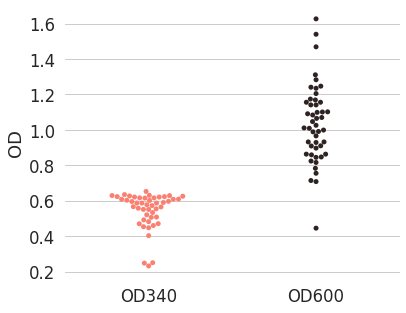

In [17]:
fig, ax = plt.subplots(figsize=(6, 5))
fontsize = 16
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
sns.swarmplot(data=df, 
              linewidth=0,
              x='Protocol',
              y='Value',
              palette="dark:salmon_r"
              )
sns.despine(left=True, bottom=True)
ax.set(xlabel=None, ylabel="OD")

fig.savefig(
    f"{user_params['output_file_path']}/swarm_both.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

Per line:

In [18]:
line_names = []
df_340 = df[df['Protocol']=='OD340'].reset_index()
for i in range(int(len(df_340)/3)):
    line_names.append(str(df_340['Line Name'][3*i])[3:-3])
# line_names

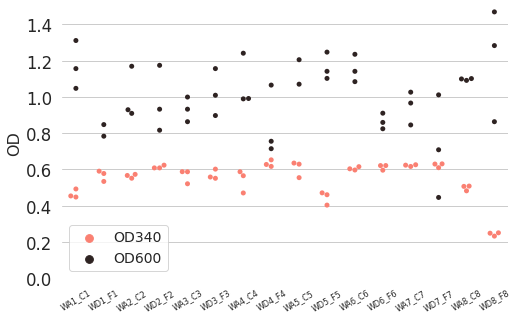

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))
fontsize = 14
sns.set_style("whitegrid")
g = sns.swarmplot(data=df, 
              linewidth=0,
              x='Line Description',
              y='Value',
              hue='Protocol',
              palette="dark:salmon_r"
              )
g.set_xticklabels(line_names, fontsize=8, rotation = 30)
plt.legend(fontsize=fontsize)
sns.despine(left=True, bottom=True)
ax.set_ylabel("OD", fontsize=fontsize+2)
ax.set_xlabel(None)
plt.ylim([0, 1.5])

fig.savefig(
    f"{user_params['output_file_path']}/swarm_per_design.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

### Plot OD measurements per well

In [21]:
data_od600 = df[df['Protocol']=='OD600'].pivot('Row', 'Column')['Value']
data_od340 = df[df['Protocol']=='OD340'].pivot('Row', 'Column')['Value']

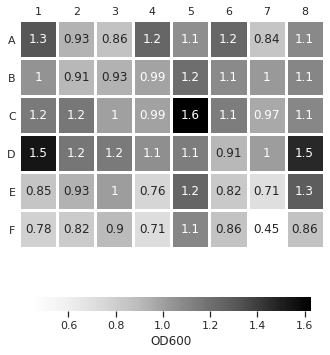

In [22]:
fig = plt.figure(figsize=(10,6))
sns.set(font_scale = 1)
ax = sns.heatmap(data=data_od600, 
                 linewidths=3, 
                 linecolor="w",
                 square= True,
                 cmap="Greys", #Greys, YlGn
                 cbar_kws={"orientation": "horizontal",
                           "shrink": 0.5,
                           'label': 'OD600'
                          },
                 annot = True,
                )
ax.set(xlabel=None, ylabel=None)
plt.yticks(rotation = 0)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
fig.savefig(
    f"{user_params['output_file_path']}/OD600.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

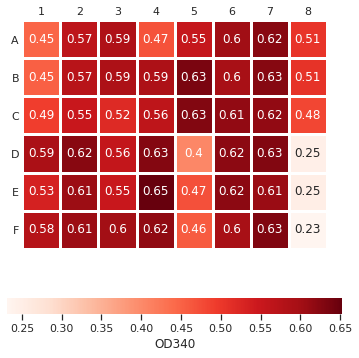

In [23]:
fig = plt.figure(figsize=(10,6))
colormap = sns.color_palette("light:salmon", as_cmap=True)
colormap = "Reds"
sns.set_context("notebook", font_scale=1., rc={"lines.linewidth": 2.5})
ax = sns.heatmap(data_od340, 
                 linewidths=3, 
                 linecolor="w",
                 square= True,
                 cmap=colormap,
                 cbar_kws={"orientation": "horizontal",
                           "shrink": 0.6,
                           'label': 'OD340'
                          },
                 annot = True,
                )
ax.set(xlabel=None, ylabel=None)
plt.yticks(rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
fig.savefig(
    f"{user_params['output_file_path']}/OD340.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

Check improvement over the previous cycles

In [34]:
best_dbtl1 = np.mean([0.61,0.61,0.6,0.58])
best_dbtl3_1 = np.mean(data_od340.iloc[:3,0])
best_dbtl3_2 = np.mean([data_od340.iloc[:3,7]])
stand = np.mean([data_od340.iloc[3:6,7]])

In [32]:
best_dbtl3_1/best_dbtl1

1.1055555555555558

In [33]:
best_dbtl3_2/best_dbtl1

1.078388888888889

In [36]:
best_dbtl3_1 / stand

2.348636846453441

In [37]:
best_dbtl3_2 / stand

2.2909241118848107

Load training data and predictions for recommendations:

In [26]:
user_params['target_designs'] = f'../data/flaviolin/DBTL{CYCLE}/target_concentrations.csv'

In [27]:
designs_pred = pd.read_csv(user_params['target_designs'], index_col=0).reset_index()
designs_pred.drop(columns='Well', inplace=True)
designs_pred['OD340'] = df[df['Protocol']=='OD340']['Value'].values
designs_pred.head()

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340_pred,OD340_std,Label,OD340
0,0.030851,0.193823,2.968560,0.062151,13.770459,2.158244,327.434888,0.000126,0.002049,0.000767,0.000625,0.000542,0.624565,0.061922,exploitation,0.4472
1,0.030851,0.193823,2.968560,0.062151,13.770459,2.158244,327.434888,0.000126,0.002049,0.000767,0.000625,0.000542,0.624565,0.061922,exploitation,0.4533
2,0.030851,0.193823,2.968560,0.062151,13.770459,2.158244,327.434888,0.000126,0.002049,0.000767,0.000625,0.000542,0.624565,0.061922,exploitation,0.4918
3,0.026618,0.178729,5.271786,0.046587,10.728408,2.566785,338.143039,0.000106,0.001254,0.000751,0.002341,0.000775,0.616771,0.062203,exploitation,0.5900
4,0.026618,0.178729,5.271786,0.046587,10.728408,2.566785,338.143039,0.000106,0.001254,0.000751,0.002341,0.000775,0.616771,0.062203,exploitation,0.5333


In [28]:
user_params['train_data'] = f'../data/flaviolin/DBTL{CYCLE}/train_pred.csv'

In [29]:
train_pred = pd.read_csv(user_params['train_data'], index_col=0)
train_pred

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340,OD340_pred,OD340_std,OD340_cv_pred,OD340_cv_std,Label
0,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.4422,0.380331,0.061722,0.399012,0.062488,train
1,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3405,0.380331,0.061722,0.399012,0.062488,train
2,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3397,0.380331,0.061722,0.399012,0.062488,train
3,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3602,0.380331,0.061722,0.399012,0.062488,train
4,0.009185,0.380499,1.156774,0.007971,11.618192,5.030266,50.607910,0.000155,0.000152,0.000029,0.000410,0.000277,0.2699,0.272069,0.061773,0.271477,0.066630,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.032352,2.681768,6.293779,0.003636,13.057300,1.678010,433.346634,0.000258,0.002099,0.000391,0.007259,0.000835,0.5844,0.569786,0.061782,0.470041,0.053597,train
188,0.032352,2.681768,6.293779,0.003636,13.057300,1.678010,433.346634,0.000258,0.002099,0.000391,0.007259,0.000835,0.5646,0.569786,0.061782,0.470041,0.053597,train
189,0.003932,0.309966,1.206566,0.010760,9.146237,0.502864,52.253707,0.000030,0.000304,0.000100,0.000726,0.000098,0.2745,0.280968,0.061725,0.276981,0.070134,standard
190,0.003932,0.309966,1.206566,0.010760,9.146237,0.502864,52.253707,0.000030,0.000304,0.000100,0.000726,0.000098,0.2829,0.280968,0.061725,0.276981,0.070134,standard


In [30]:
from sklearn.metrics import r2_score

def predictions_vs_observations(
    designs,
    train,
    errorbars_flag=False,
    xlim=None,
    ylim=None,
):
    
    plt.style.use("seaborn-white")

    fontsize = 20

    fig, ax = plt.subplots(figsize=(7, 7))
    
    obs_all = np.append(train['OD340'], designs['OD340'])
    pred_all = np.append(train['OD340_cv_pred'], designs['OD340_pred'])
    pred_std_all = np.append(train['OD340_cv_std'], designs['OD340_std'])
    
    # Plot Scatter Plot
    if errorbars_flag:
        plt.errorbar(
            obs_all,
            pred_all,
            yerr=1.96 * pred_std_all,
            fmt='none',
            ecolor="lightgray",
            elinewidth=1,
            alpha=0.5,
            zorder=0
        )
            
    plt.scatter(
        train['OD340'], 
        train['OD340_cv_pred'], 
        color="gray",
        label='train'
    )

    standard = train[train['Label']=='standard']
    plt.scatter(
        standard['OD340'], 
        standard['OD340_cv_pred'],
        label='standard',
        color="k"
    )
    
    standard_des = designs[designs['Label']=='standard']
    plt.scatter(standard_des['OD340'], standard_des['OD340_pred'], color="k")
    
    explor_des = designs[designs['Label']=='exploration']
    plt.scatter(
        explor_des['OD340'], 
        explor_des['OD340_pred'], 
        color="orange",
        label='exploration'
    )
    
    exploit_des = designs[designs['Label']=='exploitation']
    plt.scatter(
        exploit_des['OD340'], 
        exploit_des['OD340_pred'], 
        color="r",
        label='exploitation'
    )
    
    r2_train = round(r2_score(train['OD340'], train['OD340_cv_pred']), 2)
    
    r2_all = round(r2_score(obs_all, pred_all), 2)

    ax.set_title(f"$R^2$={r2_train}", fontsize=fontsize)
    ax.set_xlabel("Observations", fontsize=fontsize)
    ax.set_ylabel("Cross-validation predictions", fontsize=fontsize)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    if xlim is None:
        ax.set_xlim(lims)
    else:
        ax.set_xlim(xlim)

    if ylim is None:
        ax.set_ylim(lims)
    else:
        ax.set_ylim(ylim)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    
    plt.legend(loc='best', 
#                shadow=False, 
               fontsize=fontsize-4)

    plt.tick_params(axis="both", which="major", labelsize=fontsize)
    plt.show()

    fig.savefig(
        user_params['output_file_path']
        + "/predictions_vs_observations.png",
        bbox_inches="tight",
        transparent=False,
        dpi=300,
    )

    plt.close(fig)

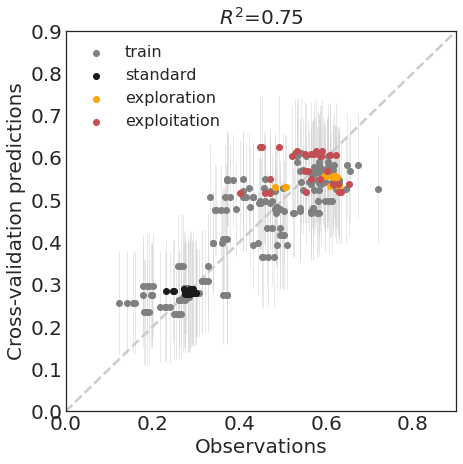

In [31]:
predictions_vs_observations(
    designs=designs_pred,
    train=train_pred,
    errorbars_flag=True,
    xlim=[0., 0.9],
    ylim=[0., 0.9],
)